# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

In [39]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import scipy
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer



from tqdm import tqdm
import os



#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.model_selection  import GridSearchCV


# Reading Data

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('/home/budukhyash/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000 """, con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [10]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [11]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [12]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [13]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [14]:
!wget --header 'Host: files.pythonhosted.org' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:64.0) Gecko/20100101 Firefox/64.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://pypi.org/' --header 'Upgrade-Insecure-Requests: 1' 'https://files.pythonhosted.org/packages/81/80/858ef502e80baa6384b75fd5c89f01074b791a13b830487f9e25bdce50ec/gensim-3.7.3.tar.gz' --output-document 'gensim-3.7.3.tar.gz'

--2019-06-27 19:29:43--  https://files.pythonhosted.org/packages/81/80/858ef502e80baa6384b75fd5c89f01074b791a13b830487f9e25bdce50ec/gensim-3.7.3.tar.gz
Resolving files.pythonhosted.org (files.pythonhosted.org)... 151.101.1.63, 151.101.65.63, 151.101.129.63, ...
Connecting to files.pythonhosted.org (files.pythonhosted.org)|151.101.1.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23369699 (22M) [binary/octet-stream]
Saving to: ‘gensim-3.7.3.tar.gz’

gensim-3.7.3.tar.gz 100%[===================>]  22.29M   116MB/s    in 0.2s    

2019-06-27 19:29:43 (116 MB/s) - ‘gensim-3.7.3.tar.gz’ saved [23369699/23369699]



In [15]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [16]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [18]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [19]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based 


In [20]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

<h2><font color='red'>[3.2] Preprocess Review Text</font></h2>

In [21]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:16<00:00, 2715.93it/s]


In [22]:
final['Text'].values[0]

'My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.'

In [23]:
preprocessed_reviews[0]

'dogs loves chicken product china wont buying anymore hard find chicken products made usa one isnt bad good product wont take chances till know going china imports'

In [24]:
final['CleanedText']=preprocessed_reviews

In [25]:
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product available victor traps unreal course t...


In [26]:
total_points=final

In [27]:
final.shape

(46071, 11)

In [28]:
# Sorting data based on time
total_points["Time"] = pd.to_datetime(total_points["Time"], unit = "s")
total_points = total_points.sort_values(by = "Time")

In [29]:
final['Score'].value_counts()

1    38479
0     7592
Name: Score, dtype: int64

# Logistic Regression

In [30]:
X=total_points['CleanedText']
Y=total_points['Score']

from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting

In [31]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
   
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred



In [32]:
def plotCM(cm):
    class_label=["negative","positive"]
    df_cm=pd.DataFrame(cm,index=class_label,columns=class_label)
    sb.heatmap(df_cm,annot=True,fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [33]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [44]:
def auc_plots(X_train_vec,X_test_vec,best_c):
    
    lr = LogisticRegression(C=best_c,n_jobs=-1)
    lr.fit(X_train_vec,y_train)
    
    
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    
    y_train_pred =  lr.predict_proba(X_train_vec)[:,1]
    y_test_pred =  lr.predict_proba(X_test_vec)[:,1]
    
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("C: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()

    print("="*100)

    from sklearn.metrics import confusion_matrix
    
    print("Train confusion matrix")
    train_cm=confusion_matrix(y_train,predict(y_train_pred, train_thresholds, train_fpr, train_tpr))
    plotCM(train_cm)
    
    print("="*100)
    
    print("Test confusion matrix")
    test_cm=confusion_matrix(y_test,predict(y_test_pred,test_thresholds,test_fpr,test_tpr))
    plotCM(test_cm)
    
    


In [35]:
def GridSearch(X_train_vec):
    lr=LogisticRegression()

    parameters = {'C':[0.5, 0.1, 0.05, 0.01, 0.005, 0.004, 0.003]}

    clf = GridSearchCV(lr, parameters, cv=5, scoring='roc_auc',n_jobs=-1,return_train_score=True)

    clf.fit(X_train_vec, y_train)

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

    plt.plot(parameters['C'], train_auc, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(parameters['C'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

    plt.plot(parameters['C'], cv_auc, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(parameters['C'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

    plt.scatter(parameters['C'], train_auc, label='Train AUC points')
    plt.scatter(parameters['C'], cv_auc, label='CV AUC points')
    
    print(clf.best_params_)

    plt.legend()
    plt.xlabel("Lambda: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.grid()
    plt.show()
    

## BOW

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)


{'C': 0.1}


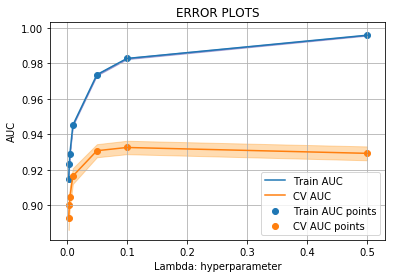

In [40]:
GridSearch(X_train_bow)

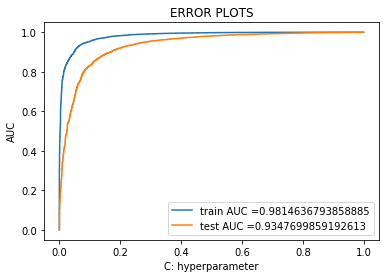

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.8711705864868499 for threshold 0.767


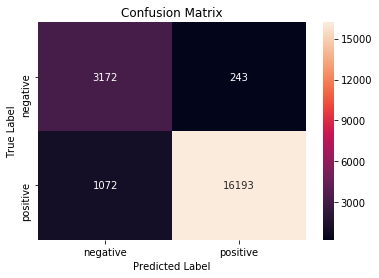

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.7575730112871057 for threshold 0.809


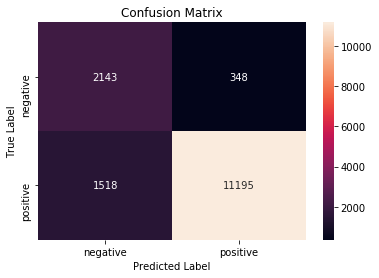

In [45]:
auc_plots(X_train_bow,X_test_bow,0.1)

## TF-IDF 

In [46]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_cv_tfidf = tfidf_vectorizer.transform(X_cv)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

{'C': 0.5}


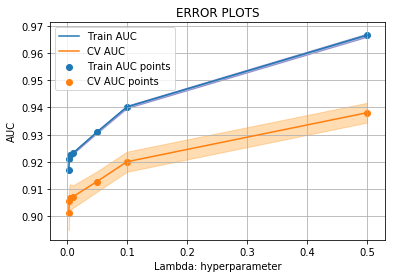

In [48]:
GridSearch(X_train_tfidf)

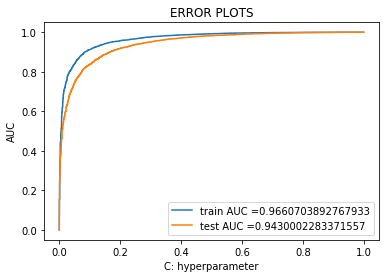

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.8248140539408302 for threshold 0.784


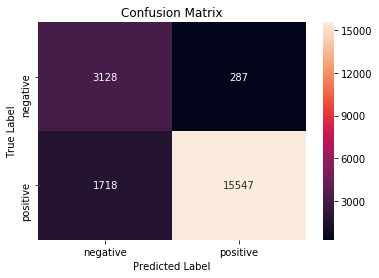

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.7584903702570187 for threshold 0.802


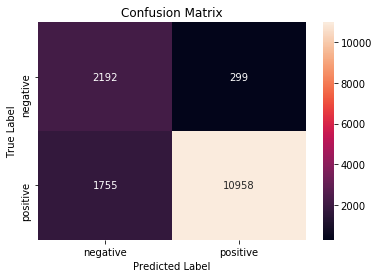

In [49]:
auc_plots(X_train_tfidf,X_test_tfidf,0.5)

# Word2Vec

In [50]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [51]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [52]:
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [53]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  8769
sample words  ['trouble', 'overflowing', 'famous', 'overseas', 'brewers', 'serendipity', 'remotely', 'adventure', 'ships', 'equivalent', 'resemble', 'odors', 'tube', 'russell', 'notification', 'fullness', 'loving', 'purple', 'sweetens', 'mcvities', 'bigger', 'come', 'teenie', 'dispenser', 'recall', 'vets', 'rover', 'successful', 'measured', 'bin', 'expected', 'cry', 'energy', 'cleanses', 'worthington', 'liquids', 'winner', 'orleans', 'exquisite', 'chicago', 'investigate', 'gnat', 'kidding', 'flexibility', 'cal', 'chip', 'gummies', 'chile', 'tummies', 'slows']


In [54]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|██████████| 20680/20680 [01:48<00:00, 190.34it/s]

(20680, 50)
[-0.44542513 -0.92018275  0.44415944 -0.56398242  0.24002844 -0.41296879
 -0.23086634  0.47659232 -0.08586044  0.13495517 -0.12917604  0.19169397
  0.4136666  -0.0989594   0.20914832  0.26323231 -0.05418318  0.18183985
  0.41534854  0.11327467  0.36731165 -0.25433428  0.92666007 -0.19656208
  0.31334688 -0.20312693  0.34343023  0.01987759  0.58140012  0.8960094
 -0.49997419  0.0612584   0.30842739  0.2696138  -0.19527047 -0.42637974
  0.58221951 -0.61880565 -0.21425816  0.35781336 -0.16934777  0.28042394
  0.23601152 -0.40607357  0.38677325  0.27065431 -0.42388124  0.18056992
  0.28180541  0.31015229]


In [55]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [56]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|██████████| 10187/10187 [00:52<00:00, 193.17it/s]

(10187, 50)
[-0.35508247 -0.16815523  0.40222244  0.29162311  0.53939152 -0.125176
  0.01552031  0.59032746  0.05375512 -0.47021664 -0.62457204 -0.17730984
  0.52098026 -0.41665628 -0.02488258 -0.1901601  -0.18638235  0.2531179
  0.54355158  0.37618448  0.3637255  -0.04394943  0.2313323  -0.33957
  0.85960091  0.03613885  1.05418496 -0.39931171  0.07575837  0.93903684
 -0.42472005 -0.19798378  0.73849333  0.22376993 -0.49400371 -0.44718612
  1.10565676 -0.56595195  0.32755092 -0.2637353  -0.13087551 -0.43637843
 -0.51639449 -0.46530647 -0.24695142 -0.02856492 -0.34647012 -0.16373316
 -0.04454433  0.87571989]


In [57]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [58]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|██████████| 15204/15204 [01:20<00:00, 188.79it/s]


(15204, 50)
[-0.38429796 -0.59339183  0.00882949 -0.19676672  0.38326219  0.00678356
 -0.17200911  0.35010689  0.19528482 -0.48376226 -0.14795411 -0.40600342
  0.73092429 -0.48441737  0.14505202  0.4032676  -0.04373086  0.08364029
  0.61172242  0.04894623  0.48825474 -0.30616291  0.21520638 -0.47097076
  0.55339953 -0.07171033  0.92962185 -0.47408426  0.18981869  0.86985864
 -0.28918548  0.03122611  0.58356937 -0.09987165 -0.05179073 -0.50201203
  0.99940952 -0.31821962  0.40882654  0.1996777  -0.05235566 -0.13315578
  0.09002184 -0.35280075  0.34571872 -0.03130636 -0.18806862  0.00626903
  0.38770792  1.13888823]


In [59]:
X_train_avg_w2v=sent_vectors_train
X_test_avg_w2v=sent_vectors_test
X_cv_avg_w2v=sent_vectors_cv

{'C': 0.5}


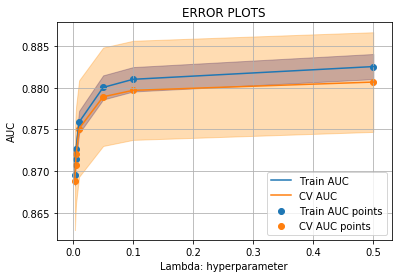

In [60]:
GridSearch(X_train_avg_w2v)

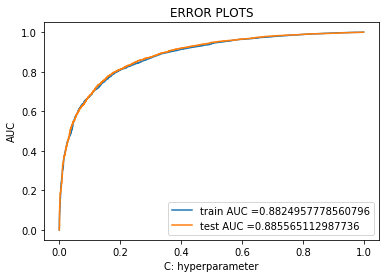

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.6499801263484254 for threshold 0.825


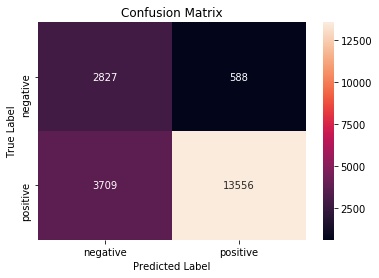

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.6553091325420614 for threshold 0.825


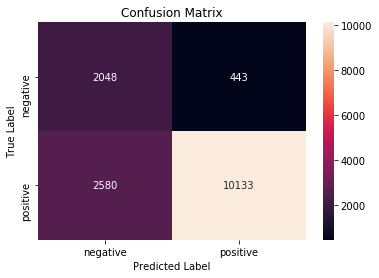

In [68]:
auc_plots(X_train_avg_w2v,X_test_avg_w2v,0.5)

# TFIDF W2V

In [61]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

## Train

In [62]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 20680/20680 [06:30<00:00, 52.93it/s]


## Test

In [63]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 15204/15204 [04:46<00:00, 53.00it/s]


## CV

In [64]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 10187/10187 [03:09<00:00, 53.75it/s]


In [65]:
X_train_tfidf_w2v=tfidf_sent_vectors_train
X_test_tfidf_w2v=tfidf_sent_vectors_test
X_cv_tfidf_w2v=tfidf_sent_vectors_cv

{'C': 0.5}


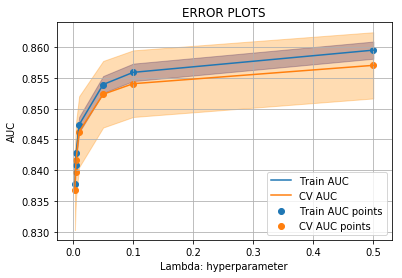

In [66]:
GridSearch(X_train_tfidf_w2v)

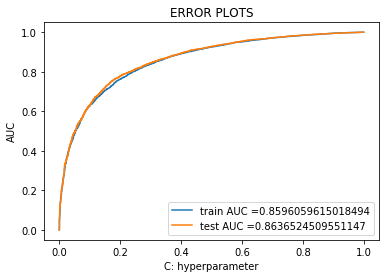

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.6117538889729854 for threshold 0.833


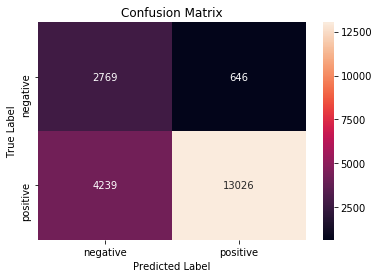

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.6246449145658738 for threshold 0.833


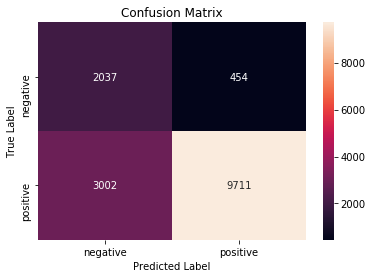

In [67]:
auc_plots(X_train_tfidf_w2v,X_test_tfidf_w2v,0.5)

In [2]:

from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "HyperParameter", "AUC"]

x.add_row(["BOW", "LR",0.1,0.93])
x.add_row(["TF-IDF", "LR",0.1,0.93])
x.add_row(["AVG W2V", "LR",0.5,0.94])
x.add_row(["TF-IDF W2V", "LR",0.5,0.86])


print(x)

+------------+-------+----------------+------+
| Vectorizer | Model | HyperParameter | AUC  |
+------------+-------+----------------+------+
|    BOW     |   LR  |      0.1       | 0.93 |
|   TF-IDF   |   LR  |      0.1       | 0.93 |
|  AVG W2V   |   LR  |      0.5       | 0.94 |
| TF-IDF W2V |   LR  |      0.5       | 0.86 |
+------------+-------+----------------+------+
